In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np


sys.path.append(os.path.join(os.getcwd(), os.pardir))
from plot import colorPanel, loader, stick
from plot.cd import cd
import glob
import json
#from plotting import cd
#from plotting import baseline_logger as bl

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [2]:
def smooth_reward_curve(x, y):
    print (len(x))
    halfwidth = min(151, int(np.ceil(len(x)/15))) # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2*k+1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2*k+1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo)/1e3)),1)
    return xsmoo[::downsample], ysmoo[::downsample]

def process_json(path):
    with open(path, 'r') as f:
        r = {'l': [], 'r': []}
        ccnt = 0
        kk = 0
        tmp = []
        ff = 1
        for line in f.readlines():
            if ff:
                ff = 0
                continue
            d = json.loads(line)
            kk += d['l']
            tmp.append(d['r'][0])
            if kk > 50:
                ccnt += 1
                r['l'].append(ccnt*50)
                kk = kk % 50
                r['r'].append(np.mean(tmp))
                tmp = []
    for k in ['l', 'r']:
        r[k] = np.array(r[k])
    return r


def average_dict(res, keys, er, rr):
    """
    :param res: the dict
    :param keys: keys
    :return: a dict with (key, (mean, std)) of results.
    """
    ret = dict()
    for k in keys:
        vs = [r[k] for r in res]
        l = min(v.shape[0] for v in vs)
        vs = [v[np.newaxis, :l] for v in vs]
        vs = np.concatenate(vs, axis=0)
        if k == 'r':
            vs = (vs-rr)/(er-rr)
        m, s = np.median(vs, axis=0), np.std(vs, axis=0, dtype=np.float64)
        ret[k] = [m, s]
    return ret

In [3]:
def get_data(prefix, criterion, er, rr):

    with cd(prefix):
        paths = glob.glob(criterion)
        d = dict()
        print (paths, criterion)
        for path in paths:
            files = glob.glob(path + '/seed-*/0.monitor.json')
            res = []
            for f in files:
                if not 'seed-10/' in f and not 'seed-12/' in f and not 'seed-14/' in f:
                    continue
                print (f)
                r = process_json(f)
                res.append(r)
            print (len(res))
            if True:
                res = average_dict(res, ['l', 'r'], er=er, rr=rr)
            d[path] = res
        #print (path)
        if len(paths) == 1:
            for k, v in d.items():
                return v
        else:
            return d

In [59]:
def plotArg(game, ax):
    env_id = game
    #env_id, traj_need = game.split('-')
    #traj_need = int(traj_need)
    colors = colorPanel.colorPanel(1).getColors()
    
    if game == 'Cooperative Navigation':
        d_type = ['Expert', 'Random', 'BC', 'Cooperative', 'Decentralized']
        draw_sym = ['-s', '-o', '-v', '-*', '-d']
        ex_num = [50, 100, 150, 200]
        re_m = np.array([[-13.5, -13.5, -13.5, -13.5], [-128.13, -128.13, -128.13, -128.13], [-56.8, -43.1, -35.6, -25.8], 
                        [-46.6, -23.1, -21.5, -15.3], [-50, -25.6, -24.1, -15.5]])
        re_s = np.array([[6,6,6,6], [32,32,32,32], [18,16,15,12], [20.8,12,12.9,7], [18.6,12.3,13.3,6.45]])
        
        re_m_n = [np.array([0,0,0,0]), np.array([1,1,1,1])]
        re_s_n = []
        for i in range(2, len(d_type)):
            re_m_n.append(-(re_m[i]-re_m[1,0])/(re_m[0,0]-re_m[1,0])+1)
        for i in range(len(d_type)):
            re_m_n[i] = re_m_n[i]+0.1
        for i in range(len(d_type)):
            re_s_n.append((re_s[i])/(re_m[0,0]-re_m[1,0])/9)
        x = [1,2,3,4]
        for i in range(len(d_type)):
            #if d_type[i] == 'Random':
            #    continue
            y_mean = re_m_n[i]
            y_upper = [y_mean[t]+re_s_n[i][t] for t in range(len(ex_num))]
            y_lower = [y_mean[t]-re_s_n[i][t] for t in range(len(ex_num))]
            ax.fill_between(
                 x, list(y_lower), list(y_upper), interpolate=True, facecolor=colors[i], linewidth=0.0, alpha=0.3
            )
            line = ax.plot(x, list(y_mean), '%s'%(draw_sym[i]), label=d_type[i], color=colors[i], rasterized=True)
            #line = ax.plot(x, list(y_mean), color=colors[i], '-s')
            print (x)
            print (y_mean)
            print (y_upper)
            print (y_lower)
        stick.cutsomStick(game, 'timesteps', ax)
        
    if game == 'Cooperative Communication':
        d_type = ['Expert', 'Random', 'BC', 'Cooperative', 'Decentralized']
        draw_sym = ['-s', '-o', '-v', '-*', '-d']
        ex_num = [50, 100, 150, 200]
        re_m = np.array([[-6.2, -6.2, -6.2, -6.2], [-62.2, -62.2, -62.2, -62.2], [-21.2, -13.2, -11.3, -10.0], 
                [-15.65, -7.11, -7.11, -7.09], [-18.6, -8.058, -8.16, -7.34]])
        re_s = np.array([[4.5, 4.5, 4.5, 4.5], [28.7, 28.7, 28.7, 28.7], [10.6, 7.4, 5.9, 5.36], 
                [10.0, 4.81, 4.805, 4.806], [10.4, 5.3, 5.47, 4.86]])
        re_m_n = [np.array([0,0,0,0]), np.array([1,1,1,1])]
        re_s_n = []
        for i in range(2, len(d_type)):
            re_m_n.append(-(re_m[i]-re_m[1,0])/(re_m[0,0]-re_m[1,0])+1)
        for i in range(len(d_type)):
            re_m_n[i] = re_m_n[i]+0.1
        for i in range(len(d_type)):
            re_s_n.append((re_s[i])/(re_m[0,0]-re_m[1,0])/9)
        x = [1,2,3,4]
        for i in range(len(d_type)):
            #if d_type[i] == 'Random':
            #    continue
            y_mean = re_m_n[i]
            y_upper = [y_mean[t]+re_s_n[i][t] for t in range(len(ex_num))]
            y_lower = [y_mean[t]-re_s_n[i][t] for t in range(len(ex_num))]
            ax.fill_between(
                 x, list(y_lower), list(y_upper), interpolate=True, facecolor=colors[i], linewidth=0.0, alpha=0.3
            )
            line = ax.plot(x, list(y_mean), '%s'%(draw_sym[i]), label=d_type[i], color=colors[i], rasterized=True)
            #line = ax.plot(x, list(y_mean), color=colors[i], '-s')
            print (x)
            print (y_mean)
            print (y_upper)
            print (y_lower)
        stick.cutsomStick(game, 'timesteps', ax)
        
        
    ax.set_ylim(-0.2,1.2)
    ax.set_xlim(0.8,4.2)
    
    ax.set_yscale('log')
    ax.invert_yaxis()
    
    ax.set_xticks([1,2,3,4])
    ax.set_yticks([0.1,0.14,0.2,0.3,0.5,1.1])
    ax.set_yticklabels(['1','0.96','0.9','0.8','0.6','0'])
    ax.set_xticklabels(['100','200','300','400'])
    #set(gca,'ydir','reverse','yscale','log')

[1, 2, 3, 4]
[ 0.1  0.1  0.1  0.1]
[0.10892857142857143, 0.10892857142857143, 0.10892857142857143, 0.10892857142857143]
[0.091071428571428581, 0.091071428571428581, 0.091071428571428581, 0.091071428571428581]
[1, 2, 3, 4]
[ 1.1  1.1  1.1  1.1]
[1.1569444444444446, 1.1569444444444446, 1.1569444444444446, 1.1569444444444446]
[1.0430555555555556, 1.0430555555555556, 1.0430555555555556, 1.0430555555555556]
[1, 2, 3, 4]
[ 0.36785714  0.225       0.19107143  0.16785714]
[0.3888888888888889, 0.23968253968253969, 0.20277777777777767, 0.17849206349206348]
[0.34682539682539687, 0.21031746031746032, 0.17936507936507928, 0.15722222222222221]
[1, 2, 3, 4]
[ 0.26875     0.11625     0.11625     0.11589286]
[0.28859126984126976, 0.12579365079365079, 0.12578373015873015, 0.12542857142857144]
[0.24890873015873011, 0.10670634920634919, 0.10671626984126983, 0.10635714285714287]
[1, 2, 3, 4]
[ 0.32142857  0.13317857  0.135       0.12035714]
[0.34206349206349201, 0.1436944444444444, 0.14585317460317454, 0.1

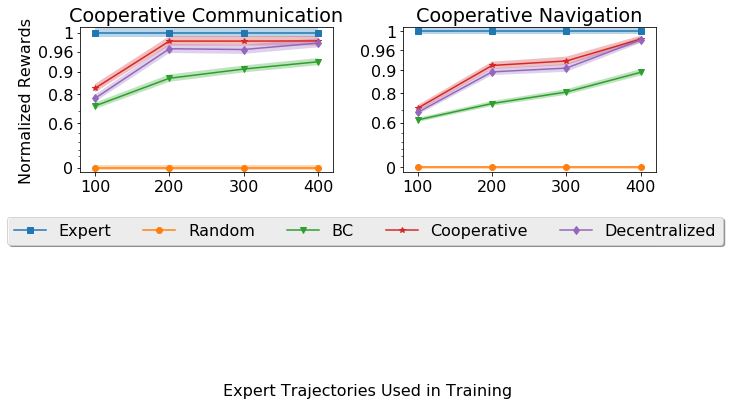

In [71]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
columns = 2
sixAtariGames = [
    'Cooperative Communication', 
    'Cooperative Navigation'
]
ax.set_xlabel('Expert Trajectories Used in Training')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')


for i, args in enumerate(sixAtariGames):
    #print(args)
    ax = fig.add_subplot(len(sixAtariGames) / columns + 1, columns, i + 1)
    plotArg(args, ax)
    if i == 0:
        #ax.set_xlabel('Expert Trajectories Used in Training')
        ax.set_ylabel('Normalized Rewards')
        #ax.xaxis.set_label_coords(1.05, -0.025)


#plt.legend(loc=4)

lgd = plt.legend(loc='upper center', bbox_to_anchor=(-0.15, -0.25),
          fancybox=True, shadow=True, ncol=5)

#plt.title('Expert Trajectories Used in Training')
fig.tight_layout()
fig.savefig('cooperative_result.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')